In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import keras

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import time
from tabulate import tabulate

In [2]:
# read dataset
df = pd.read_csv("Dataset/bank_marketing/bank-additional/bank-additional/bank-additional-full.csv", delimiter=";")

In [4]:
# preprocessing steps for numerical and categorical data (replace output value, replace missing value, encode, scale)

# replace 'yes' with 1 and 'no' with 0
df['y'] = df['y'].replace({'yes': 1, 'no': 0})

numeric_features = df.drop(["y"], axis = 1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = df.select_dtypes(include=['object']).columns

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

C:\Users\PC\AppData\Local\Temp\ipykernel_25728\2830836920.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['y'] = df['y'].replace({'yes': 1, 'no': 0})


In [5]:
# split dataset
X = df.drop(["y"], axis = 1)
y = df["y"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [6]:
# storing performance result
performance_result = [
    ["Algorithm", "Accuracy", "Precision", "Recall", "F1 Score", "F1 Score (Macro)", "Duration"]
]

# function for performance metrics
def print_performance(y_test, y_pred, model, et, st):
    # confusion matrix
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Converted', 'Converted'],
                yticklabels=['Not Converted', 'Converted'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    # classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    # evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    f1_macro = f1_score(y_test, y_pred, average="macro")

    performance_result.append([model, accuracy, precision, recall, f1, f1_macro, et - st])

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}")
    print(f"F1 Score (Macro): {f1_macro}")
    print(f"Duration (s): {et-st}")

In [7]:
# cross validation functions
def model_cross_validation(model, name, X_training):
    cv_scores = cross_validate(model, X_training, y_train, cv=5, scoring=['accuracy', 'precision', 'recall', 'f1'])
    
    cv_results_df = pd.DataFrame({
        "Fold": [1, 2, 3, 4, 5],
        "Accuracy": cv_scores['test_accuracy'],
        "Precision": cv_scores['test_precision'],
        "Recall": cv_scores['test_recall'],
        "F1-Score": cv_scores['test_f1']
    })

    cv_results_df.loc["Mean"] = ["Mean Accuracy", cv_scores['test_accuracy'].mean(), cv_scores['test_precision'].mean(), cv_scores['test_recall'].mean(), cv_scores['test_f1'].mean()]
    cv_results_df.loc["Std Dev"] = ["Mean Standard Deviation", cv_scores['test_accuracy'].std(), cv_scores['test_precision'].std(), cv_scores['test_recall'].std(), cv_scores['test_f1'].std()]
    cv_results_df.to_csv(str(name) + "_cross_validation.csv", index=False)

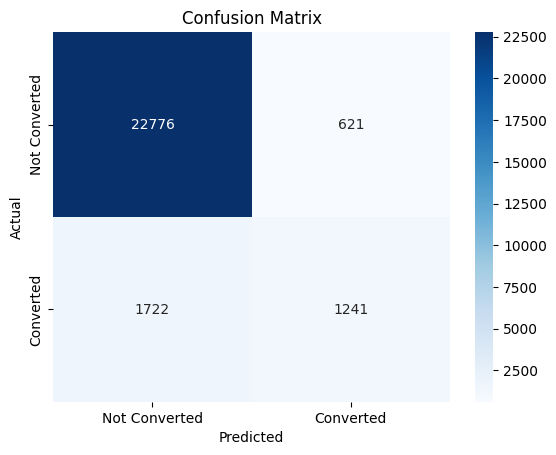

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     23397
           1       0.67      0.42      0.51      2963

    accuracy                           0.91     26360
   macro avg       0.80      0.70      0.73     26360
weighted avg       0.90      0.91      0.90     26360

Accuracy: 0.9111153262518968
Precision: 0.6664876476906552
Recall: 0.41883226459669254
F1 Score: 0.5144041450777203
F1 Score (Macro): 0.7327423168232322
Duration (s): 0.2048792839050293


In [8]:
# lr
st = time.time()
lr_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', LogisticRegression(max_iter = 1000))])

lr_model.fit(X_train, y_train)
et = time.time()

y_pred = lr_model.predict(X_test)

print_performance(y_test, y_pred, "LR", et, st)
model_cross_validation(lr_model, "lr", X_train)

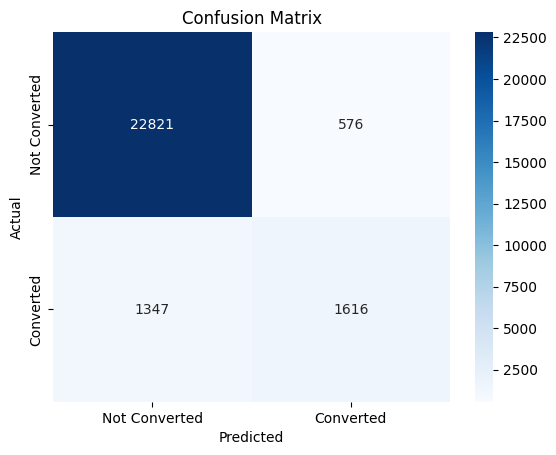

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     23397
           1       0.74      0.55      0.63      2963

    accuracy                           0.93     26360
   macro avg       0.84      0.76      0.79     26360
weighted avg       0.92      0.93      0.92     26360

Accuracy: 0.9270485584218513
Precision: 0.7372262773722628
Recall: 0.5453931825852177
F1 Score: 0.6269641125121241
F1 Score (Macro): 0.7932676128628107
Duration (s): 0.0925145149230957


In [9]:
# knn
st = time.time()
knn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', KNeighborsClassifier())])

knn_model.fit(X_train, y_train)
et = time.time()

y_pred = knn_model.predict(X_test)

print_performance(y_test, y_pred, "KNN", et, st)
model_cross_validation(knn_model, "knn", X_train)

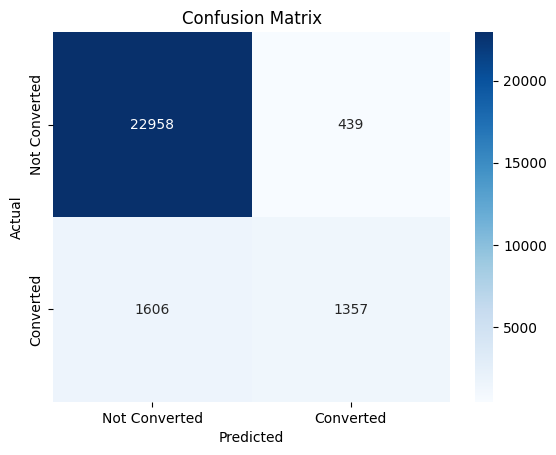

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.96     23397
           1       0.76      0.46      0.57      2963

    accuracy                           0.92     26360
   macro avg       0.85      0.72      0.76     26360
weighted avg       0.91      0.92      0.91     26360

Accuracy: 0.9224203338391502
Precision: 0.7555679287305123
Recall: 0.45798177522780964
F1 Score: 0.5702878756041185
F1 Score (Macro): 0.7638245324518789
Duration (s): 15.143640518188477


In [10]:
# svm
st = time.time()
svm_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', SVC())])

svm_model.fit(X_train, y_train)
et = time.time()

y_pred = svm_model.predict(X_test)

print_performance(y_test, y_pred, "SVM", et, st)
model_cross_validation(svm_model, "svm", X_train)

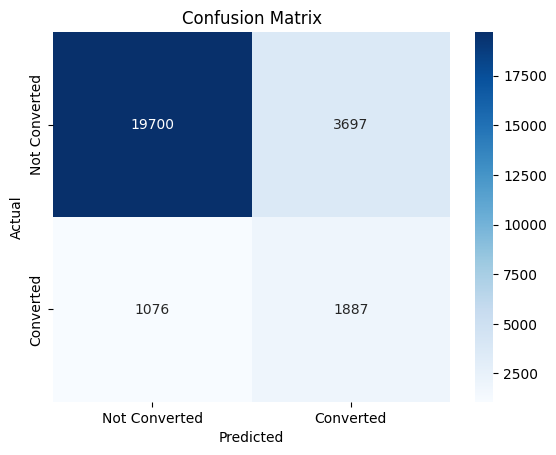

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.84      0.89     23397
           1       0.34      0.64      0.44      2963

    accuracy                           0.82     26360
   macro avg       0.64      0.74      0.67     26360
weighted avg       0.88      0.82      0.84     26360

Accuracy: 0.8189301972685887
Precision: 0.3379297994269341
Recall: 0.6368545393182585
F1 Score: 0.44155844155844154
F1 Score (Macro): 0.6667530056704439
Duration (s): 0.12041568756103516


In [11]:
# nb
st = time.time()
nb_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', BernoulliNB())])

nb_model.fit(X_train, y_train)
et = time.time()

y_pred = nb_model.predict(X_test)

print_performance(y_test, y_pred, "NB", et, st)
model_cross_validation(nb_model, "nb", X_train)

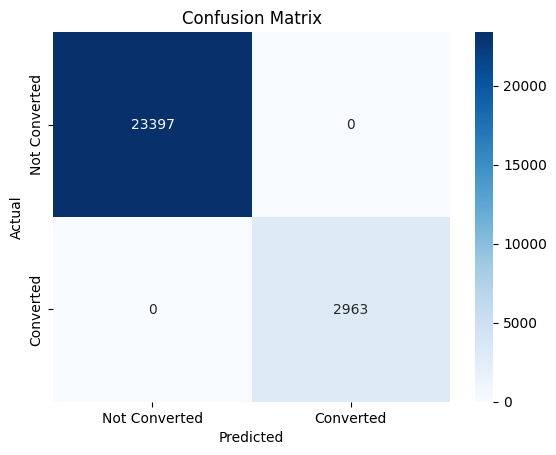

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23397
           1       1.00      1.00      1.00      2963

    accuracy                           1.00     26360
   macro avg       1.00      1.00      1.00     26360
weighted avg       1.00      1.00      1.00     26360

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
F1 Score (Macro): 1.0
Duration (s): 0.30080389976501465


In [12]:
# dt
st = time.time()
dt_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', DecisionTreeClassifier())])

dt_model.fit(X_train, y_train)
et = time.time()

y_pred = dt_model.predict(X_test)

print_performance(y_test, y_pred, "DT", et, st)
model_cross_validation(dt_model, "dt", X_train)

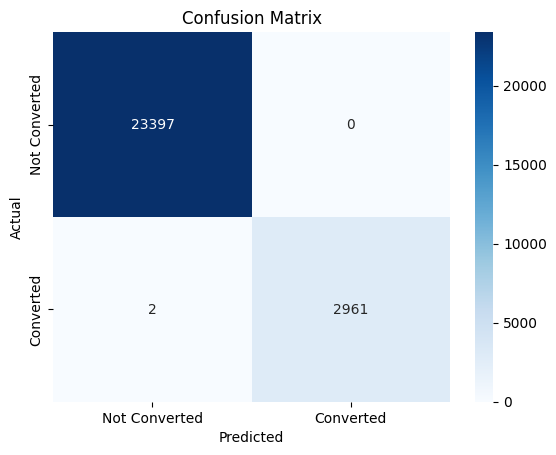

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23397
           1       1.00      1.00      1.00      2963

    accuracy                           1.00     26360
   macro avg       1.00      1.00      1.00     26360
weighted avg       1.00      1.00      1.00     26360

Accuracy: 0.9999241274658573
Precision: 1.0
Recall: 0.9993250084373946
F1 Score: 0.99966239027684
F1 Score (Macro): 0.9998098257906125
Duration (s): 2.472196578979492


In [13]:
# rf
st = time.time()
rf_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier())])

rf_model.fit(X_train, y_train)
et = time.time()

y_pred = rf_model.predict(X_test)

print_performance(y_test, y_pred, "RF", et, st)
model_cross_validation(rf_model, "rf", X_train)

C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


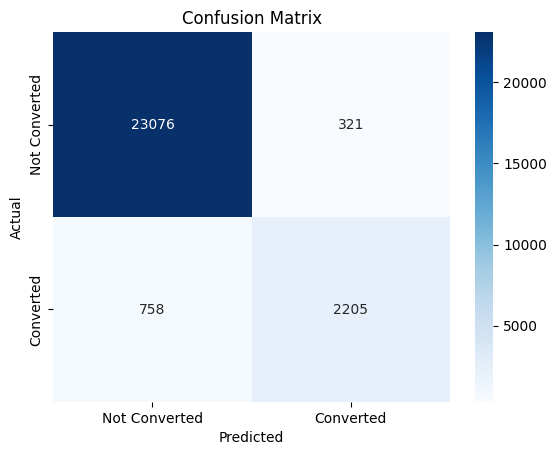

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     23397
           1       0.87      0.74      0.80      2963

    accuracy                           0.96     26360
   macro avg       0.92      0.87      0.89     26360
weighted avg       0.96      0.96      0.96     26360

Accuracy: 0.9590667678300455
Precision: 0.8729216152019003
Recall: 0.7441781977725278
F1 Score: 0.8034250318819457
F1 Score (Macro): 0.890289933315155
Duration (s): 29.1138117313385


C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\PC\anaconda3\envs\test_hyperbolic\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [14]:
# nn
st = time.time()
nn_model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', MLPClassifier())])

nn_model.fit(X_train, y_train)
et = time.time()

y_pred = nn_model.predict(X_test)

print_performance(y_test, y_pred, "NN", et, st)
model_cross_validation(nn_model, "nn", X_train)

C:\Users\PC\AppData\Local\Temp\ipykernel_25728\2629766587.py:23: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  honn_model = KerasClassifier(build_fn=create_honn_model, epochs=10, batch_size=1, verbose=0)


824/824 [==============================] - 1s 915us/step


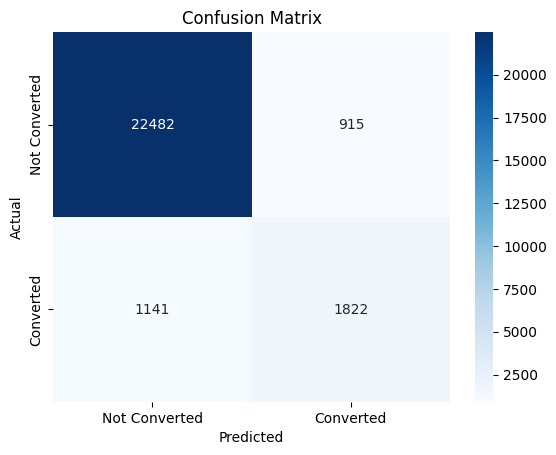

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96     23397
           1       0.67      0.61      0.64      2963

    accuracy                           0.92     26360
   macro avg       0.81      0.79      0.80     26360
weighted avg       0.92      0.92      0.92     26360

Accuracy: 0.9220030349013657
Precision: 0.6656923639020825
Recall: 0.6149173135335808
F1 Score: 0.639298245614035
F1 Score (Macro): 0.797786085801488
Duration (s): 539.073988199234
206/206 [==============================] - 0s 924us/step


In [18]:
# honn
def higher_order_nn(input_dim, order):
    inputs = Input(shape=(input_dim,))
    x = inputs

    for i in range(order):
        x = Dense(64, activation="relu")(x) # input layer

    outputs = Dense(1, activation="sigmoid")(x) # output layer

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

def create_honn_model():
    input_dim = X_train_preprocessed.shape[1]
    order = 2
    model = higher_order_nn(input_dim, order)
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

st = time.time()
X_train_preprocessed = preprocessor.fit_transform(X_train)
honn_model = KerasClassifier(build_fn=create_honn_model, epochs=10, batch_size=1, verbose=0)
honn_model.fit(X_train_preprocessed, y_train)
et = time.time()

X_test_preprocessed = preprocessor.transform(X_test)
y_pred = honn_model.predict(X_test_preprocessed)
y_pred = (y_pred > 0.5).astype(int)

print_performance(y_test, y_pred, "HONN", et, st)
model_cross_validation(honn_model, "honn", X_train_preprocessed)

In [19]:
# performance comparison table
print(tabulate(performance_result, headers = "firstrow", tablefmt = "outline"))

# save to csv file
df_performance = pd.DataFrame(performance_result[1:], columns = performance_result[0])
df_performance.to_csv('performance_overview.csv', index = False)

+-------------+------------+-------------+----------+------------+--------------------+-------------+
| Algorithm   |   Accuracy |   Precision |   Recall |   F1 Score |   F1 Score (Macro) |    Duration |
+=============+============+=============+==========+============+====================+=============+
| LR          |   0.911115 |    0.666488 | 0.418832 |   0.514404 |           0.732742 |   0.204879  |
| KNN         |   0.927049 |    0.737226 | 0.545393 |   0.626964 |           0.793268 |   0.0925145 |
| SVM         |   0.92242  |    0.755568 | 0.457982 |   0.570288 |           0.763825 |  15.1436    |
| NB          |   0.81893  |    0.33793  | 0.636855 |   0.441558 |           0.666753 |   0.120416  |
| DT          |   1        |    1        | 1        |   1        |           1        |   0.300804  |
| RF          |   0.999924 |    1        | 0.999325 |   0.999662 |           0.99981  |   2.4722    |
| NN          |   0.959067 |    0.872922 | 0.744178 |   0.803425 |           0.890